In [2]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

import sys
sys.path.append('/Users/max/HiPACE/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['font.size'] = 16
plt.style.use('classic')

# print(plt.rcParams.keys())

from scipy.integrate import quad
import scipy.special as special

ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/linearSI/Gaussian/', check_all_files = True)
beamInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/Gaussian/reduced_beam.0000.txt')
plasmaInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/Gaussian/reduced_plasma.0000.txt')

lts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/linearSI/LoadedGaussian/', check_all_files = True)
lbeamInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/LoadedGaussian/reduced_beam.0000.txt')
lplasmaInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/LoadedGaussian/reduced_plasma.0000.txt')

ExmBy, info = ts.get_field('ExmBy', iteration = 0)
EZ = ts.get_field('Ez', iteration = 0)[0]
rho, _ = ts.get_field('rho', iteration = 0)
By, _ = ts.get_field('By', iteration = 0)
jz, _ = ts.get_field('jz_beam', iteration = 0)

lExmBy, linfo = lts.get_field('ExmBy', iteration = 0)
lEZ = lts.get_field('Ez', iteration = 0)[0]
lrho, _ = lts.get_field('rho', iteration = 0)
lBy, _ = lts.get_field('By', iteration = 0)
ljz, _ = lts.get_field('jz_beam', iteration = 0)

In [3]:
def ppc(x, y, z):
    return (53 * x) * (69 * y) * (34 * z)

def NbStep():
    w, Id = ts.get_particle(species = 'beam', iteration = 0, var_list = ['w', 'id'])
    # the last id is the number of particles (unweighted)
    # the id's start at 1
    return w[0] * Id[-1]

def GeV2P(pG: float) -> float:
    """
    Calculates momentum value for HiPACE++ input file from GeV/c value
    
    Parameters
    ----------
    pG : float
        momentum in GeV/c
    
    Returns
    -------
    p : float
        momentum in HiPACE++ input file units
    """
    pG *= 1e9 * constants.e / constants.c # 1 [GeV/c] = eV / (m/s) = kg m / s

    return pG / (constants.m_e * constants.c)

def nb(Nb: float, dr:float, dz:float) -> float:
    return Nb /((2 * np.pi)**1.5 * dr**2 * dz) # m^-3

def skinDepth(ne):
    """
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in m
    """

    ne *= 1e6 # cm^-3 -> m^-3
    wp = np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # 1/s (SI)
    kp_inv = constants.c / wp # m
    
    return kp_inv

def E0(n0: float) -> float:
    kp = skinDepth(n0) ** -1 # m^-1
    return constants.m_e * constants.c**2 * kp / constants.e # V/m

def gaussian(z, dz, mu = 0):
    return 1 / (dz * np.sqrt(2 * np.pi)) * np.exp(-(z - mu)**2 / (2 * dz**2))

def gaussianR(r, dr, mu = 0):
    return 1 / (dr**2 * 2 * np.pi) * np.exp(-(r - mu)**2 / (2 * dr**2))

def gaussian2(z, dz1, mu1, dz2, mu2):
    return gaussian(z, dz1, mu1) + gaussian(z, dz2, mu2)

def gaussianRderiv(r, dr, mu = 0):
    return -(r - mu) / dr**2 * gaussianR(r, dr, mu)

def step(z, dz: float, mu: float = 0):
    return 1 / (2 * dz) * np.heaviside((dz - abs(z - mu)), 1.) # m^-1

def step2(z, dz1, mu1, dz2, mu2):
    return step(z, dz1, mu1) + step(z, dz2, mu2)

def leftright(r0: float, r: np.ndarray) -> np.ndarray:
    left = np.heaviside(r0 - r, 0.5)
    right = np.heaviside(r - r0, 0.5)

    return left, right

def g0(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * ((special.i0(kp * r) * special.k0(kp * r0) * left + special.i0(kp * r0) * special.k0(kp * r) * right))

def g1(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    sgn = np.sign(r)
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * sgn * ((special.i1(kp * r) * special.k1(kp * r0) * left + special.i1(kp * r0) * special.k1(kp * r) * right))

def longitudinal(xi: np.ndarray, dz: float, Nb: float, n0: float, sin: bool, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    Parameters
    ----------
    mu_w : float
        longitudinal location of witness bunch (in m).  Defaults to 0.
    """
    kp = skinDepth(n0) ** -1 # m^-1

    # z = Nb * gaussian(xi, dz) # m^-1
    
    if gauss:
        if sin:
            # W_z = -kp * np.sin(kp * xi) # m^-1
            if load:
                Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
            else:
                Xi = np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
        else:
            # W_z = -kp * np.cos(kp * xi) # m^-1
            if load:
                Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
            else:
                Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
    else:
        if sin:
            # Xi = np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
            # Xi = np.array([quad(lambda Z: -kp * Nb / (2 * dz) * np.heaviside(dz - abs(Z), 1.) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            if load:
                Xi = np.array([quad(lambda Z: -kp * Nb * step2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            else:
                Xi = np.array([quad(lambda Z: -kp * Nb * step(Z, dz, 0) * np.sin(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
        else:
            # Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian(Z, dz) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED
            # Xi = -np.array([quad(lambda Z: -kp * Nb / (2 * dz) * np.heaviside(dz - abs(Z), 1.) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            if load:
                Xi = -np.array([quad(lambda Z: -kp * Nb * step2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
            else:
                Xi = -np.array([quad(lambda Z: -kp * Nb * step(Z, dz, 0) * np.cos(kp * (z - Z)), z, 1.e-4, limit = int(1e3))[0] for z in xi]) # m^-1
    
    # Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)

    return Xi

def makefield(xi, r):
    n, m = len(xi), len(r)

    F = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            F[i, j] = r[i] * xi[j]

    return F # [F] = [r] * [xi]

def n1(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    Parameters
    ----------
    n0 : float
        plasma electron density (in cm^-3)

    Returns
    -------
    n_1 : np.ndarray
        plasma electron density perturbation (in m^-3)
    """

    if gauss:
        R = gaussianR(r, dr) # m^-2
    else:
        R = 1 / (np.pi * dr**2) * np.heaviside(dr - abs(r), 1.) # m^-2

    Xi = longitudinal(xi, dz, Nb, n0, sin = True, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    n_1 = makefield(Xi, R) # m^-3

    return Xi, R, n_1 / (1e6 * n0)

def Ez(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0, eV = False) -> tuple:
    """
    Parameters
    ----------
    eV : bool
        whether to output Ez in GeV/m (True) or V/m (False).  Defaults to False.
    """
    kp = skinDepth(n0) ** -1 # m^-1

    Xi = longitudinal(xi, dz, Nb, n0, sin = False, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    if gauss:
        r_int = kp * constants.e * np.array([quad(lambda R: gaussianR(R, dr) * g0(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # C m^-1
    else:
        r_int = kp * constants.e * np.array([quad(lambda R: 1 / (np.pi * dr**2) * g0(r0, R, n0) * R, 0, dr)[0] for r0 in r]) # C m^-1

    E_z = makefield(Xi, r_int) # C m^-2

    C = 1 / (4 * np.pi * constants.epsilon_0) # m/F = C^-1 V m

    E_0 = E0(n0) # V/m
    # print(E0)

    if eV:
        return Xi, r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_z / E_0

def EzR_analytic(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, eV = False) -> tuple:
    r = abs(r) # m
    
    kp = skinDepth(n0) ** -1 # m^-1

    left, right = leftright(dr, r)

    Xi = longitudinal(xi, dz, Nb, n0, sin = False, gauss = False, load = False, mu_w = 0) # m^-1

    # C = constants.e * kp / (2 * np.pi * dr**2 * constants.epsilon_0) # C m^-1 * m^-2 * m/F = m^-2 * C * V / C = V m^-2
    C = constants.e / (np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m

    r_int = left * r * (special.i1(kp * r) * special.k0(kp * r) + special.i0(kp * r) * (special.k1(kp * r) - (dr / r) * special.k1(kp * dr))) + right * dr * special.i1(kp * dr) * special.k0(kp * r) # m

    E_z = makefield(Xi, r_int) # unitless

    E_0 = E0(n0) # V/m

    if eV:
        return r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return r_int, C * E_z / E_0

def Er(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0, eV = False) -> tuple:
    kp = skinDepth(n0) ** -1 # m^-1
    
    # C = constants.e / (np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m

    C = constants.e / (4 * np.pi * constants.epsilon_0) # C * m/F = C * m * V / C = V m
    E_0 = E0(n0) # V/m

    sgn = np.sign(-r)
    r = abs(r) # m

    Xi = longitudinal(xi, dz, Nb, n0, sin = True, gauss = gauss, load = load, mu_w = mu_w) # m^-1

    left, right = leftright(dr, r)

    if gauss:
        r_int = sgn * np.array([quad(lambda R: gaussianRderiv(R, dr) * g1(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # m^-3 * m * m = m^-1
    else:
        r_int = -4 * sgn / dr * (left * special.k1(kp * dr) * special.i1(kp * r) + right * special.i1(kp * dr) * special.k1(kp * r)) # m^-1 (Note: -4π*dr * 1/(π*dr^2) = -4/dr)

    E_r = makefield(Xi, r_int) # m^-2

    if eV:
        return Xi, r_int, constants.e * C * E_r * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_r / E_0

def Bphi(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:

    kp = skinDepth(n0) ** -1 # m^-1

    C = Nb * constants.c * constants.e * constants.mu_0 / (4 * np.pi) # m/s * C * kg m /(s^2 A^2) = m/s * A s * kg m /(s^2 A^2) = kg m^2 /(s^2 A) = T m^2
    
    # E_0 = E0(n0) # V/m
    # If want to normalize to E0, need to normalize by E0/c since (V/m) / (m/s) = Vs/m^2 = T

    sgn = np.sign(-r)
    r = abs(r) # m

    left, right = leftright(dr, r)

    # same radial component as Er, but the longitudinal profile of Bphi is the same as the drive beam longitudinal profile
    if gauss:
        if load:
            Xi = -gaussian2(xi, dz, 0, dz, mu_w) # m^-1
        else:
            Xi = -gaussian(xi, dz) # m^-1
        r_int = sgn * np.array([quad(lambda R: gaussianRderiv(R, dr) * g1(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # m^-3 * m * m = m^-1
    else:
        if load:
            Xi = -step2(xi, dz, 0, dz, mu_w) # m^-1
        else:
            Xi = -step(xi, dz) # m^-1
        r_int = -4 * sgn / dr * (left * special.k1(kp * dr) * special.i1(kp * r) + right * special.i1(kp * dr) * special.k1(kp * r)) # m^-1 (Note: -4π*dr * 1/(π*dr^2) = -4/dr)

    B_phi = makefield(Xi, r_int) # m^-2

    return Xi, r_int, C * B_phi # T

def EDensity(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss: bool, load: bool, mu_w = 0) -> tuple:
    """
    From analysis
    """

    E_z = Ez(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] * E0(n0) # V/m
    E_r = Er(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] * E0(n0) # V/m
    B_phi = Bphi(r, dr, xi, dz, Nb, n0, gauss = gauss, load = load, mu_w = mu_w)[2] # T

    u = 1 / 2 * (constants.epsilon_0 * (E_z**2 + E_r**2) + 1 / constants.mu_0 * B_phi**2) # kg m^-1 s^-2 = J m^-3
    
    return u

def EDensitySim(iteration = 0, xyz = False):
    """
    From HiPACE++ simulation
    """
    
    i = iteration

    Ez, info = ts.get_field(field = 'Ez', iteration = i)
    ExmBy, _ = ts.get_field(field = 'ExmBy', iteration = i)
    EypBx, _ = ts.get_field(field = 'EypBx', iteration = i)
    By, _ = ts.get_field(field = 'By', iteration = i)
    Bx, _ = ts.get_field(field = 'Bx', iteration = i)
    Bz, _ = ts.get_field(field = 'Bz', iteration = i)

    Ex = ExmBy + constants.c * By
    Ey = EypBx - constants.c * Bx
    
    u = 1 / 2 * (constants.epsilon_0 * (Ex**2 + Ey**2 + Ez**2) + 1 / constants.mu_0 * (Bx**2 + By**2 + Bz**2))
    
    if xyz:
        return info, u
    else:
        return u

def getZ(F, info):
    """
    returns on-axis longitudinal slice of field
    """
    return F[:, len(info.x)//2].T




In [4]:
# DOMAIN
res = 1e-6 # m
num = 512 # m
rmin, rmax, ximin, ximax = -150e-6, 150e-6, -350e-6, 100e-6 # m
r, xi = np.linspace(rmin, rmax, num - 1), np.linspace(ximin, ximax, num)
# r, xi = np.arange(rmin, rmax, res), np.arange(ximin, ximax, res)

profile = abs(getZ(jz, info))
lprofile = abs(getZ(ljz, linfo))
r[r==0] = 1e-12


Nb = 4e7
n0 = 8e16   # cm^-3
dr = 20e-6  # m
dz = 15e-6  # m

kp = skinDepth(n0) ** -1 # m^-1
xi0 = -3 * np.pi / kp # m

/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_1661/1868855090.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_1661/1868855090.py:116: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Xi = np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.sin(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1
/var/folders/l9/q33h82k16xx50gmpcg10_ymh0000gn/T/ipykernel_1661/1868855090.py:122: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Xi = -np.array([quad(lambda Z: -kp * Nb * gaussian2(Z, dz, 0, dz, mu_w) * np.cos(kp * (z - Z)), z, 1e-2)[0] for z in xi]) # m^-1 EXTRA MINUS SIGN NEEDS TO BE ADDRESSED

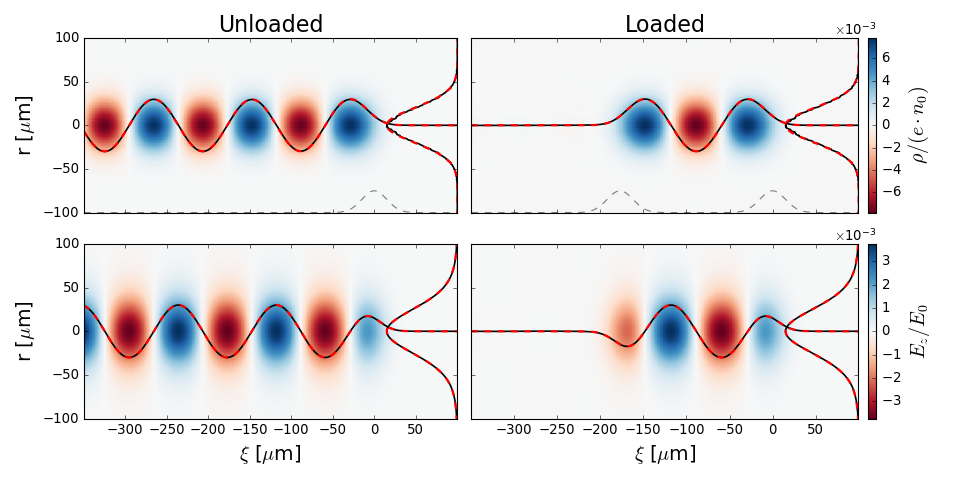

In [24]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.25]})

off = 0
idx = np.argmin(abs(info.x - off))

_, R_1, _ = n1(r, dr, xi, dz, Nb, n0, gauss = True, load = False, mu_w = xi0)
z = longitudinal(xi, dz, Nb, n0, True, gauss = True, load = False, mu_w = xi0)
_, lR_1, _ = n1(r, dr, xi, dz, Nb, n0, gauss = True, load = True, mu_w = xi0)
lz = longitudinal(xi, dz, Nb, n0, True, gauss = True, load = True, mu_w = xi0)

axs[0, 0].pcolormesh(1e6 * info.z, 1e6 * info.x, rho.T * 1e-6 / (constants.e * n0), cmap = 'RdBu')
axs[0, 0].plot(1e6 * info.z, 25 * gaussian(info.z, dz, 0)/max(gaussian(info.z, dz, 0)) - 100, 'k--', alpha = .5)
axs[0, 0].plot(-.85e2 * max(abs(rho[idx]))**-1 * rho[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
axs[0, 0].plot(-.85e2 * max(R_1)**-1 * R_1 + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')
axs[0, 0].plot(1e6 * info.z, 30 * max(abs(rho[:, len(rho)//2]))**-1 * rho[:, len(rho)//2], 'k', linewidth = 1.5)
axs[0, 0].plot(1e6 * xi, 30 * max(abs(z))**-1 * z, 'r--', linewidth = 2.)
axs[0, 0].set_title('Unloaded', fontsize = 20)

imgRho = axs[0, 1].pcolormesh(1e6 * info.z, 1e6 * info.x, lrho.T * 1e-6 / (constants.e * n0), cmap = 'RdBu')
axs[0, 1].plot(1e6 * info.z, 25 * gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)/max(gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)) - 100, 'k--', alpha = .5)
axs[0, 1].plot(-.85e2 * max(abs(lrho[idx]))**-1 * lrho[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
axs[0, 1].plot(-.85e2 * max(lR_1)**-1 * lR_1 + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')
axs[0, 1].plot(1e6 * info.z, 30 * max(abs(lrho[:, len(lrho)//2]))**-1 * lrho[:, len(lrho)//2], 'k', linewidth = 1.5)
axs[0, 1].plot(1e6 * xi, 30 * max(abs(lz))**-1 * lz, 'r--', linewidth = 2.)
cbRho = fig.colorbar(imgRho, ax = axs[0, 1], pad = .02)
cbRho.formatter.set_powerlimits((0, 0))
cbRho.formatter.set_useMathText(True)
cbRho.set_label(r'$\rho/(e \cdot n_0)$', fontsize = 18)
axs[0, 1].set_title('Loaded', fontsize = 20)

_, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = True, load = False, mu_w = xi0, eV = False)
z = longitudinal(xi, dz, Nb, n0, False, gauss = True, load = False, mu_w = xi0)
_, lR, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = True, load = True, mu_w = xi0, eV = False)
lz = longitudinal(xi, dz, Nb, n0, False, gauss = True, load = True, mu_w = xi0)

axs[1, 0].pcolormesh(1e6 * info.z, 1e6 * info.x, EZ.T / E0(n0), cmap = 'RdBu')
# axs[1, 0].plot(1e6 * info.z, 25 * gaussian(info.z, dz, 0)/max(gaussian(info.z, dz, 0)) - 100, 'k--', alpha = .5)
axs[1, 0].plot(-.85e2 * max(abs(EZ[idx]))**-1 * EZ[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
axs[1, 0].plot(-.85e2 * max(R)**-1 * R + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')
axs[1, 0].plot(1e6 * info.z, 30 * max(abs(EZ[:, len(EZ)//2]))**-1 * EZ[:, len(EZ)//2], 'k', linewidth = 1.5)
axs[1, 0].plot(1e6 * xi, 30 * max(abs(z))**-1 * z, 'r--', linewidth = 2.)

imgEz = axs[1, 1].pcolormesh(1e6 * info.z, 1e6 * info.x, lEZ.T / E0(n0), cmap = 'RdBu')
# axs[1, 1].plot(1e6 * info.z, 25 * gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)/max(gaussian2(info.z, dz, 0, dz, -3*np.pi*kp**-1)) - 100, 'k--', alpha = .5)
axs[1, 1].plot(-.85e2 * max(abs(lEZ[idx]))**-1 * lEZ[idx] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
axs[1, 1].plot(-.85e2 * max(lR)**-1 * lR + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')
axs[1, 1].plot(1e6 * info.z, 30 * max(abs(lEZ[:, len(lEZ)//2]))**-1 * lEZ[:, len(lEZ)//2], 'k', linewidth = 1.5)
axs[1, 1].plot(1e6 * xi, 30 * max(abs(lz))**-1 * lz, 'r--', linewidth = 2.)
cbEz = fig.colorbar(imgEz, ax = axs[1, 1], pad = .02)
cbEz.formatter.set_powerlimits((0, 0))
cbEz.formatter.set_useMathText(True)
cbEz.set_label(r'$E_z/E_0$', fontsize = 18)

for ax in axs[-1, :]:
    ax.set_xlim(1e6 * info.zmin, 1e6 * info.zmax)
    ax.set_xlabel(r'$\xi$ [$\mu$m]', fontsize = 18)
for ax in axs[:, 0]:
    ax.set_ylim(-100, 100)
    ax.set_ylabel(r'r [$\mu$m]', fontsize = 18)




plt.tight_layout()
# plt.savefig('/Users/max/HiPACE/recovery/images/LinearRhoEz.png', bbox_inches = 'tight', dpi = 300)
plt.show()